In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()

import sys

# Follow instructions here to get cvxopt working. --- painful!!! 
#https://stackoverflow.com/questions/46009925/how-to-install-cvxopt-on-on-windows-10-on-python-3-6
from cvxopt import matrix, solvers

# Regularized Linear Regression 

### Common code for questions 7-10

Load training and testing data in pandas dataframes

In [2]:
def load_data():
    column_names = ['digit', 'intensity', 'symmetry']
    sep = '\s+'
    features_train = pd.read_table('http://www.amlbook.com/data/zip/features.train', sep=sep, names=column_names)
    features_test = pd.read_table('http://www.amlbook.com/data/zip/features.test', sep=sep, names=column_names)
    return features_train, features_test

In [3]:
features_train, features_test = load_data()

Set output labels for classifiers

In [4]:
classifiers_one_vs_all = dict(
    {'zero_vs_all': 0,
     'one_vs_all': 1,
     'two_vs_all': 2,
     'three_vs_all': 3,
     'four_vs_all': 4,
     'five_vs_all': 5,
     'six_vs_all': 6,
     'seven_vs_all': 7,
     'eight_vs_all': 8,
     'nine_vs_all': 9
    }
)

In [5]:
classifiers_one_vs_five = {'one_vs_five': [1,5]}

Create one-versus-all and one-versus-five dataframes

In [6]:
def create_one_vs_all_dataframe(df, classifiers):
    # add binary labels to dataframe
    one_vs_all = pd.DataFrame(df, copy=True)
    for class_label, digit in classifiers.items():
        labels = one_vs_all.loc[one_vs_all['digit'] == digit, 'digit']
        labels.loc[:] = 1.0
        one_vs_all[class_label] = labels
        
    one_vs_all.fillna(-1.0, inplace=True)
    return one_vs_all

In [7]:
features_train_one_vs_all = create_one_vs_all_dataframe(features_train, classifiers_one_vs_all)
features_test_one_vs_all = create_one_vs_all_dataframe(features_test, classifiers_one_vs_all)

In [8]:
def create_one_vs_one_dataframe(df, classifiers):
    # add binary labels to dataframe  
    for class_label in classifiers.keys():
        digits = classifiers[class_label]
        one_vs_one = pd.DataFrame(df.loc[df['digit'].isin(digits),:], copy=True)
        for digit in digits:
            labels = one_vs_one.loc[one_vs_one['digit'] == digit, 'digit']
            labels.loc[:] = 1.0
            one_vs_one[class_label] = labels
            break
        
    one_vs_one.fillna(-1.0, inplace=True)
    return one_vs_one

In [9]:
features_train_one_vs_five = create_one_vs_one_dataframe(features_train, classifiers_one_vs_five)
features_test_one_vs_five = create_one_vs_one_dataframe(features_test, classifiers_one_vs_five)

Get dataset (inputs / outputs) for a specific classifier

In [10]:
def get_dataset(df, class_label):
    inputs = np.array(df.loc[:, ['intensity', 'symmetry']])
    outputs = np.array(df.loc[:, class_label])
    data = np.column_stack((inputs, outputs))
    return data

Implementation of regularized least-squares linear regression for classiﬁcation that minimizes:

$$\frac{1}{N}\sum_{n=1}^{N}(\textbf{w}^{T}\textbf{z}_{n}-y_{n})^{2}+\frac{\lambda}{N}\textbf{w}^{T}\textbf{w}$$

where $\textbf{w}$ includes $w_{0}$.

In [11]:
class LinearRegression:
    """ Class that performs regularized least-squares linear regression for classification. """
    
    def __init__(self, transform=False):
        """ Create a Linear Regression Algorithm. 
        Args:
        transform (bool): If True, apply a feature transform z = (1, x1, x2, x1.x2, x1^2, x2^2) to the inputs (x1, x2)
                          Otherwise, use inputs as they are so z = (1, x1, x2)
        """
        self.transform = transform
    
    def fit(self, inputs, outputs, llambda=1.0):    
        """Fit the training data using the regularized least-squares linear regression learning algorithm
        Args:
        inputs (np.ndarray): Inputs
        outputs (np.ndarray): Outputs
        llambda (float): Regularization parameter
        Returns:
        np.ndarray: Weights
        """      
        # get inputs and outputs
        Z = self.transform_inputs(inputs)
        y = outputs
        
        # linear regression solution with regularization
        Z_trans = np.transpose(Z)
        normZ = np.matmul(Z_trans, Z)  
        I = np.identity(np.size(normZ, axis=0))
        weights = np.matmul(np.linalg.inv(np.add(normZ, llambda * I)), np.matmul(Z_trans, y))
        return weights
    
    def binary_error(self, weights, inputs, outputs):    
        """Compute binary classification error of sample
        Args:
        weights (np.ndarray): Weights of hypothesis
        inputs (np.ndarray): Inputs
        outputs (np.ndarray): Outputs
        Returns:
        float: Binary classification error (fraction of misclassified points in the sample)
        """
        Z = self.transform_inputs(inputs)
        y = outputs
        
        g = [np.sign(np.dot(weights.T, z)) for z in Z]
        return sum(g != y) / len(y)        
         
    # privates
    def transform_inputs(self, inputs):
        ones = np.ones(len(inputs)).reshape(len(inputs), 1)
        x1 = inputs[:, 0].reshape(len(inputs), 1)
        x2 = inputs[:, 1].reshape(len(inputs), 1)
        
        if self.transform:
            return np.concatenate((ones, x1, x2, x1*x2, x1**2, x2**2), axis=1)
        else:
            return np.concatenate((ones, x1, x2), axis=1)

Compute in-sample and out-of-sample errors

In [12]:
def in_out_sample_errors(classifiers, features_train, features_test=pd.DataFrame(), llambda=1.0, transform=False):
    results = []
    
    for class_label in classifiers.keys():
            # get training data
            dataset_train = get_dataset(features_train, class_label)
            inputs_train = dataset_train[:, 0:2]
            outputs_train = dataset_train[:, 2]
            
            # fit the model
            lr = LinearRegression(transform)
            weights = lr.fit(inputs_train, outputs_train, llambda)
            
            # compute in-sample error
            error_in_sample = lr.binary_error(weights, inputs_train, outputs_train)
            
            # get testing data
            error_out_sample = None
            if not features_test.empty:
                dataset_test = get_dataset(features_test, class_label)
                inputs_test = dataset_test[:, 0:2]
                outputs_test = dataset_test[:, 2]
                
                # compute out-of-sample error
                error_out_sample =  lr.binary_error(weights, inputs_test, outputs_test)
            
            # add to results
            result = {'classifier': class_label,
                      'transform': transform,
                      'lambda': llambda,
                      'ein': error_in_sample,
                      'eout': error_out_sample}
            results.append(result)
            
    return results

Print errors

In [13]:
def print_binary_errors(results, print_classifiers=None, print_errors='both'):   
    if print_errors not in ['ein', 'eout', 'both']:
        raise ValueError('"print_errors" must either "ein", "eout" or "both"')
    
    for result in results:
        if isinstance(print_classifiers, list) and result['classifier'] not in print_classifiers:
            continue
        
        if print_errors == 'ein':
            print('For transform = {0} and λ = {1}, the "{2}" classifier in-sample error Ein = {3}'
                  .format(result['transform'], result['lambda'], result['classifier'], round(result['ein'], 3)))
        elif print_errors == 'eout':
            print('For transform = {0} and λ = {1}, the "{2}" classifier in-sample error Eout = {3}'
                  .format(result['transform'], result['lambda'], result['classifier'], round(result['eout'], 3)))
        elif print_errors == 'both':
            print('For transform = {0} and λ = {1}, the "{2}" classifier in-sample error Ein = {3} '
                  'and the out-of-sample-error Eout = {4}'
                  .format(result['transform'], result['lambda'], result['classifier'], 
                          round(result['ein'], 3), round(result['eout'], 3)))

### Question 7

Compute in-sample error for 5-versus-all through to 9-versus-all classifier for $\lambda$ = 1 without a feature transform $z = x = (1, x_{1}, x_{2})$

In [14]:
results = in_out_sample_errors(classifiers_one_vs_all, features_train_one_vs_all, llambda=1.0, transform=False)

In [15]:
print_binary_errors(results, print_classifiers=['five_vs_all', 
                                                'six_vs_all', 
                                                'seven_vs_all', 
                                                'eight_vs_all', 
                                                'nine_vs_all'],
                    print_errors='ein')

For transform = False and λ = 1.0, the "five_vs_all" classifier in-sample error Ein = 0.076
For transform = False and λ = 1.0, the "six_vs_all" classifier in-sample error Ein = 0.091
For transform = False and λ = 1.0, the "seven_vs_all" classifier in-sample error Ein = 0.088
For transform = False and λ = 1.0, the "eight_vs_all" classifier in-sample error Ein = 0.074
For transform = False and λ = 1.0, the "nine_vs_all" classifier in-sample error Ein = 0.088


### Question 8

Compute out-of-sample error for 0-versus-all through to 4-versus-all classifier for $\lambda$ = 1 with a feature transform $z = (1, x_{1}, x_{2}, x_{1}x_{2}, x_{1}^2, x_{2}^2)$

In [16]:
results = in_out_sample_errors(classifiers_one_vs_all, features_train_one_vs_all, features_test_one_vs_all, llambda=1.0, 
                               transform=True)

In [17]:
print_binary_errors(results, print_classifiers=['zero_vs_all', 
                                                'one_vs_all', 
                                                'two_vs_all', 
                                                'three_vs_all', 
                                                'four_vs_all'],
                    print_errors='eout')

For transform = True and λ = 1.0, the "zero_vs_all" classifier in-sample error Eout = 0.107
For transform = True and λ = 1.0, the "one_vs_all" classifier in-sample error Eout = 0.022
For transform = True and λ = 1.0, the "two_vs_all" classifier in-sample error Eout = 0.099
For transform = True and λ = 1.0, the "three_vs_all" classifier in-sample error Eout = 0.083
For transform = True and λ = 1.0, the "four_vs_all" classifier in-sample error Eout = 0.1


### Question 9

Compare the in-sample and out-of-sample errors for 0-versus-all through to 9-versus-all classifier for $\lambda$ = 1 with and without the feature transform

In [18]:
results = in_out_sample_errors(classifiers_one_vs_all, features_train_one_vs_all, features_test_one_vs_all, llambda=1.0, 
                               transform=False)

In [19]:
print_binary_errors(results, print_errors='both')

For transform = False and λ = 1.0, the "zero_vs_all" classifier in-sample error Ein = 0.109 and the out-of-sample-error Eout = 0.115
For transform = False and λ = 1.0, the "one_vs_all" classifier in-sample error Ein = 0.015 and the out-of-sample-error Eout = 0.022
For transform = False and λ = 1.0, the "two_vs_all" classifier in-sample error Ein = 0.1 and the out-of-sample-error Eout = 0.099
For transform = False and λ = 1.0, the "three_vs_all" classifier in-sample error Ein = 0.09 and the out-of-sample-error Eout = 0.083
For transform = False and λ = 1.0, the "four_vs_all" classifier in-sample error Ein = 0.089 and the out-of-sample-error Eout = 0.1
For transform = False and λ = 1.0, the "five_vs_all" classifier in-sample error Ein = 0.076 and the out-of-sample-error Eout = 0.08
For transform = False and λ = 1.0, the "six_vs_all" classifier in-sample error Ein = 0.091 and the out-of-sample-error Eout = 0.085
For transform = False and λ = 1.0, the "seven_vs_all" classifier in-sample er

In [20]:
results = in_out_sample_errors(classifiers_one_vs_all, features_train_one_vs_all, features_test_one_vs_all, llambda=1.0, 
                               transform=True)

In [21]:
print_binary_errors(results, print_errors='both')

For transform = True and λ = 1.0, the "zero_vs_all" classifier in-sample error Ein = 0.102 and the out-of-sample-error Eout = 0.107
For transform = True and λ = 1.0, the "one_vs_all" classifier in-sample error Ein = 0.012 and the out-of-sample-error Eout = 0.022
For transform = True and λ = 1.0, the "two_vs_all" classifier in-sample error Ein = 0.1 and the out-of-sample-error Eout = 0.099
For transform = True and λ = 1.0, the "three_vs_all" classifier in-sample error Ein = 0.09 and the out-of-sample-error Eout = 0.083
For transform = True and λ = 1.0, the "four_vs_all" classifier in-sample error Ein = 0.089 and the out-of-sample-error Eout = 0.1
For transform = True and λ = 1.0, the "five_vs_all" classifier in-sample error Ein = 0.076 and the out-of-sample-error Eout = 0.079
For transform = True and λ = 1.0, the "six_vs_all" classifier in-sample error Ein = 0.091 and the out-of-sample-error Eout = 0.085
For transform = True and λ = 1.0, the "seven_vs_all" classifier in-sample error Ein

### Question 10

Compare the in-sample and out-of-sample errors for 0-versus-all through to 9-versus-all classifier for λ = 1.0 and λ = 0.01 with feature transform

In [22]:
results = in_out_sample_errors(classifiers_one_vs_five, features_train_one_vs_five, features_test_one_vs_five, llambda=1.0, 
                               transform=True)

In [23]:
print_binary_errors(results, print_errors='both')

For transform = True and λ = 1.0, the "one_vs_five" classifier in-sample error Ein = 0.005 and the out-of-sample-error Eout = 0.026


In [24]:
results = in_out_sample_errors(classifiers_one_vs_five, features_train_one_vs_five, features_test_one_vs_five, llambda=0.01, 
                               transform=True)

In [25]:
print_binary_errors(results, print_errors='both')

For transform = True and λ = 0.01, the "one_vs_five" classifier in-sample error Ein = 0.004 and the out-of-sample-error Eout = 0.028


# Support Vector Machines 

### Common code for questions 11-12

Create training data

In [26]:
def get_training_set():
    return np.array([1., 0., -1.,
                     0., 1., -1.,
                     0., -1., -1.,
                     -1., 0., 1.,
                     0., 2., 1.,
                     0., -2., 1.,
                     -2., 0., 1.]).reshape(7, 3)

In [27]:
train_data = get_training_set()

Plot data

In [28]:
def plot_data(features, label, features_names=['$x_{1}$', '$x_{2}$'], plot_hyperplanes=False):
    plt.scatter(features[:, 0], features[:, 1], c=label, cmap='rainbow');
    plt.xlabel(features_names[0]);
    plt.ylabel(features_names[1]);
    
    if plot_hyperplanes:
        eps = 1e-12 # to prevent divide by zero
        xfit = np.linspace(-3.5, 3.5)
        
        for w1, w2, b in [(-1., 1., -0.5), (1., -1., -0.5), (1., 0., -0.5), (0., 1., -0.5)]:
            slope = -w1 / (w2+eps)
            intercept = -b / (w2+eps)
            yfit =  slope * xfit + intercept
            plt.plot(xfit, yfit, label="w1 = {0}, w2 = {1}, b = {2}".format(str(w1), str(w2), str(b)))
            plt.legend(loc='upper left')
        
        plt.xlim(-3.5, 3.5);
        plt.ylim(-3.5, 5.5);

We see that the data is not linearly separable in the $\mathcal{X}$ space

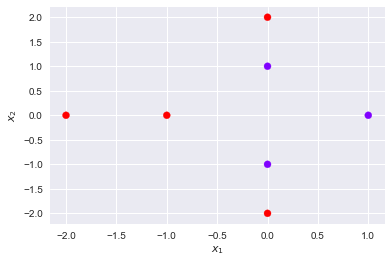

In [29]:
plot_data(train_data[:, 0:2], train_data[:, 2])

We transform this training set into another two-dimensional space $\mathcal{Z}$

$$z_{1}=x_{2}^{2}-2x_{1}-1\qquad z_{2}=x_{1}^{2}-2x_{2}+1$$

In [30]:
def transform_inputs(inputs):
    x1 = inputs[:, 0].reshape(len(inputs), 1)
    x2 = inputs[:, 1].reshape(len(inputs), 1)
    return np.concatenate((x2**2 - 2*x1 - 1, x1**2 - 2*x2 + 1), axis=1)

In [31]:
train_inputs = transform_inputs(train_data[:, 0:2])

We see that the data is now linearly separable in the $\mathcal{Z}$ space (the last two points map on to the same point (3, 5))

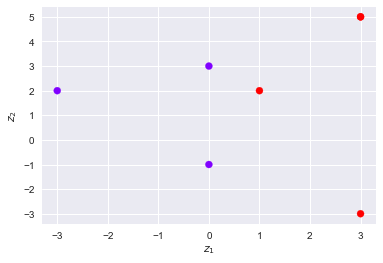

In [32]:
plot_data(train_inputs[:, 0:2], train_data[:, 2], features_names=['$z_{1}$', '$z_{2}$'])

Implementation of hard-margin Support Vector Machines (SVM) classification learning algorithm using the kernel:

$$K(x,x')=(1+\textbf{x}_{T}\textbf{x}')^{2}$$

which corresponds to a second-order polynomial transformation)

In [33]:
class SVM:
    """ Class that performs hard-margin Support Vector Machines (SVM) classification using polynomial kernel of degree 2. """
    def __init__(self, kernel='poly', Q=2, gamma=1.0):
        """ Create a Support Vector Machine Algorithm (SVM). 
        Args:
        kernel (string): Kernel to use, "poly" (polynomial) or "rbf" (radial basis function)
        Q (int): Degree of the polynomial kernel (Q >= 0)
        gamma (float): Constant in the RBF kernel
        """
        if kernel not in ['poly','rbf']:
            raise ValueError('Kernel must be "poly" or "rbf".')
        
        self.kernel = kernel
        self.Q = Q
        self.gamma = gamma
    
    def fit(self, inputs, outputs):
        """Fit the training data using the hard-margin Support Vector Machines (SVM) learning algorithm.
        Args:
        inputs (np.ndarray): Input points.
        outputs (np.ndarray): Targets.
        Returns:
        Tuple(np.ndarray, np.ndarray, np.ndarray, float): alphas, support vectors, support vector outputs, b
        """ 
        xn = inputs
        yn = outputs
        N = len(xn)
        
        mat = []
        for row_idx in range(0, N):
            for col_idx in range(0, N):
                if self.kernel == 'poly':
                    kernel = self.kernel_poly(xn[row_idx], xn[col_idx])
                elif self.kernel == 'rbf':
                    kernel = self.kernel_rbf(xn[row_idx], xn[col_idx])
                val = yn[row_idx] * yn[col_idx] * kernel
                mat.append(val)
        mat = np.array(mat).reshape((N, N))
        
        # form matrices for quadratic programming solver
        dim = len(xn[0])
        P = matrix(mat, tc='d')
        q = matrix(-np.ones(N), tc='d')
        b = matrix(0.0, tc='d')
        A = matrix(yn, tc='d')
        A = A.trans()
        G = matrix(-np.identity(N), tc='d')
        h = matrix(np.zeros(N), tc='d')
        
        #print('P = ', P)
        #print('q = ', q)
        #print('G = ', G)
        #print('h = ', h)
        #print('A = ', A)
        #print('b = ', b)
                
        # call qp solver to compute weights
        solvers.options['show_progress'] = False # supress solver output
        
        sol = solvers.qp(P, q, G, h, A, b)
        alpha = np.array(list(sol['x']))
        #print('alpha = ', sol['x'])
        
        weights = np.zeros(dim)
        sv = []
        sv_alphas = []
        sv_outputs = []
        for n in range(0, N):
            if alpha[n] > 1e-5: # => xn[n] is support vector
                sv.append(xn[n])
                sv_alphas.append(alpha[n])
                sv_outputs.append(yn[n])
                    
        # compute number of support vectors 
        num_sv = len(sv)
        if (num_sv == 0):
            raise Exception('There are no support vectors.')
        
        bs = []
        for m in range(0, num_sv):
            b = sv_outputs[m]
            for n in range(0, num_sv):
                if self.kernel == 'poly':
                    kernel = self.kernel_poly(sv[n], sv[m])
                elif self.kernel == 'rbf':
                    kernel = self.kernel_rbf(sv[n], sv[m])
                b -= sv_alphas[n] * sv_outputs[n] * kernel
            bs.append(b)
                
        bs_round = np.round(bs, 1)
        #print('bs sv = ', bs)
        
        #print('bs = ', bs)
        #print('bs_round = ', bs_round)
        #print('np.unique(bs_round) = ', np.unique(bs_round))
        
        #if (len(np.unique(bs_round)) != 1):
        #    raise Exception('All support vectors must produce the same value of b.')
            
        weights = np.insert(weights, 0, b)
        #print('weights = ', weights)

        return np.array(sv_alphas), np.array(sv), np.array(sv_outputs), b
    
    def binary_error(self, sv_alphas, sv, sv_outputs, b, inputs, outputs):
        """ Evaluate binary classification error. 
        Args:
        sv_alphas (np.ndarray): Support vector Lagrange multipliers.
        sv (np.ndarray): Support vectors.
        sv_outputs (np.ndarray): Support vector outputs.
        b (float): Constant.
        inputs (np.ndarray): Inputs.
        outputs (np.ndarray): Outputs.
        Returns (float): Binary classification error percentage
        """
        x = inputs
        y = outputs
        num_sv = len(sv)
        
        gs = []
        for xm in x:
            signal = 0.0
            for n in range(0, num_sv):
                if self.kernel == 'poly':
                    kernel = self.kernel_poly(sv[n], xm)
                elif self.kernel == 'rbf':
                    kernel = self.kernel_rbf(sv[n], xm)
                signal += sv_alphas[n] * sv_outputs[n] * kernel
            signal += b
            gs.append(signal)
                
        g = np.array(np.sign(gs))
        return 100. * np.sum(y != g) / len(y)   
    
    # privates
    def kernel_poly(self, xn, xm):
        return (1.0 + np.dot(xn.T, xm))**self.Q
    
    def kernel_rbf(self, xn, xm):
        return np.exp(-self.gamma * (np.linalg.norm(xn - xm)**2))

### Question 11

Since the hyperplane is described by the equation, $\textbf{w}^{T}\textbf{z} + b = 0$, we can now plot the hyperplanes given by the values of $w_{1}$, $w_{2}$, b: 
- [-1, 1, 0.5]
- [1, -1, -0.5]
- [1, 0, -0.5]
- [0, 1, -0.5]

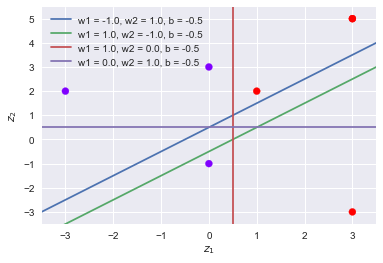

In [34]:
plot_data(train_inputs[:, 0:2], train_data[:, 2], features_names=['$z_{1}$', '$z_{2}$'], plot_hyperplanes=True)

From the plot we can see that the red hyperplane ($w_{1} = 1.0, w_{2} = 0.0, b = -0.5$) is the only one that separates the data and as expected it is orthogonal to the weight vector $w = [1.0, 0.0]$. Furthermore, by inspection we can see that it separates the data with the maximum margin (as it bisects the closest points of the two classes), and that margin is 1.  

### Question 12

In [35]:
svm = SVM()
alphas, support_vectors, outputs, b = svm.fit(train_data[:, 0:2], train_data[:, 2])
print('The number of support vectors is', len(support_vectors))

The number of support vectors is 5


# Radial Basis Functions

### Common code for questions 13-18

We experiment with the RBF model, both in regular form (Lloyd + pseudo-inverse) with K centers:

$$sign\Bigg( \sum_{k=1}^{K} w_{k}\exp(- \gamma \Vert x - \mu_{k} \Vert)^{2} + b \Bigg)$$

(notice that there is a bias term), and in kernel form (using the RBF kernel in hardmargin SVM):

$$sign\Bigg( \sum_{\alpha_{n}\gt 0} \alpha_{n}y_n\exp(- \gamma \Vert x - x_{n} \Vert)^{2} + b \Bigg)$$

The input space is X = [−1,1]×[−1,1] with uniform probability distribution, and the target is

$$f(x)=sign(x_{2}-x_{1}+0.25 \sin(\pi x_{1}))$$

which is slightly nonlinear in the X space. In each run, generate 100 training points at random using this target, and apply both forms of RBF to these training points. 

Here are some guidelines: 

- Repeat the experiment for as many runs as needed to get the answer to be stable (statistically away from ﬂipping to the closest competing answer). 

- In case a data set is not separable in the ‘Z space’ by the RBF kernel using hardmargin SVM, discard the run but keep track of how often this happens, if ever.

- When you use Lloyd’s algorithm, initialize the centers to random points in X and iterate until there is no change from iteration to iteration. If a cluster becomes empty, discard the run and repeat.


Generate training inputs

In [36]:
def generate_training_inputs(N=100):
    return np.array([np.random.uniform(-1.0, 1.0, 2) for n in range(0, N)])

Generate training targets

In [37]:
def compute_targets(inputs):
    x1 = inputs[:, 0]
    x2 = inputs[:, 1]
    return np.sign(x1 - x2 + 0.25 * np.sin(np.pi * x1))

Run SVM trials with RBF kernel

In [38]:
def run_svm_trials(N=100, n_trials=100, gamma=1.5):
    ein = 0.
    non_sep_count = 0
    
    for n_trial in range(0, n_trials):
        train_inputs = generate_training_inputs(N)
        train_outputs = compute_targets(train_inputs)
        
        svm = SVM(kernel='rbf', gamma=gamma)
        alphas, sv, sv_outputs, b = svm.fit(train_inputs, train_outputs)
        ein += svm.binary_error(alphas, sv, sv_outputs, b, train_inputs, train_outputs)
        
        if ein > 0.0:
            non_sep_count += 1
    
    return non_sep_count / n_trials

In [39]:
class KKMeans:
    """ Class that performs K-means clustering using Lloyd's algorithm. """
    
    @staticmethod
    def fit(inputs, K=3, n_runs = 1, max_iter=300, tol=0.0001):
        """ Cluster inputs into K clusters using Lloyd's algorithm. 
        Args:
        inputs (np.ndarray): Inputs.
        K (int): Number of clusters.
        n_runs (int): Number of times to run Lloyd's algorithm (it falls into local minima)
        max_iter (int): Maximum number of iterations
        tol (float): Convergence tolerance
        Returns Tuple(np.ndarray, np.ndarray): Centroids of clusters (μ1, ..., μk) and cluster labels of inputs
        """
        run_cluster_labels = []
        run_centroids = []
        
        for run in range(0, n_runs):
            
            # initialize K centroids at random (note we could also initialize clusters instead)
            centroids = generate_training_inputs(K)

            min_distance = sys.float_info.max
            for iteration in range(0, max_iter):

                # assign inputs to cluster with closest centroid
                cluster_labels = []
                for inputt in inputs:
                    distances = []
                    for centroid in centroids:
                        distance = np.linalg.norm(inputt - centroid)
                        distances.append(distance)
                    cluster_num = np.argmin(distances)
                    cluster_labels.append(cluster_num)
                    #print("{0} assigned to cluster {1}".format(inputt, cluster_num))
                #print('cluster labels = ', cluster_labels)

                # if a cluster is empty discard the run
                if set(cluster_labels) != set(range(0, K)):
                    return (np.array([]), np.array([]))

                prev_centroids = centroids

                # compute cluster centroids
                centroids = []
                for cluster_label in range(0, K):
                    input_idxs = [i for i, label in enumerate(cluster_labels) if label == cluster_label]
                    #print('indices = ', input_idxs)
                    mean_cluster = np.mean(inputs[input_idxs], axis=0)
                    #print('mean cluster = ', mean_cluster)
                    centroids.append(mean_cluster)              
                centroids = np.array(centroids)

                #print('iteration = ', iteration+1)

                # check for convergence
                #print('prev_centroids = ', prev_centroids)
                #print('centroids = ', centroids)
                if iteration > 0: 
                    if np.linalg.norm(prev_centroids - centroids) < tol and prev_cluster_labels == cluster_labels:
                        #print('Converged')
                        break

                prev_cluster_labels = cluster_labels
                
            run_centroids.append(centroids)
            run_cluster_labels.append(cluster_labels)
            
        high_count_index = KKMeans.arg_max_run_clusters(run_cluster_labels, K, n_runs)
        
        return run_centroids[high_count_index], np.array(run_centroids[high_count_index])
    
    # privates
    @staticmethod
    def arg_max_run_clusters(run_cluster_labels, K, n_runs):
        counts = {}
        run_clusters = []
        for run in range(0, len(run_cluster_labels)):
            run_cluster = []
            for k in range(0, K):
                indices = [i for i, x in enumerate(run_cluster_labels[run]) if x == k]
                run_cluster.append(indices)
            run_cluster.sort()

            if run_cluster not in run_clusters:
                run_clusters.append(run_cluster)
                counts[run] = 1
            else:
                run_clusters.append([])
                index = run_clusters.index(run_cluster)
                counts[index] += 1
                
        high_count_index = max(counts, key=counts.get)
        return high_count_index

In [40]:
class RBF:
    """ Class that performs Radial Basis Functions (RBF) classification using pseudo-inverse algorithm. """
    
    def __init__(self, gamma=1.0, K=3):
        """ Create a Radial Basis Functions Algorithm (RBF). 
        Args:
        gamma (float): Constant in the RBF kernel
        K (int): Number of clusters
        """
        self.gamma = gamma
        self.K = K
    
    def fit(self, inputs, outputs):
        """ Fit the training data using Lloyds algorithm + RBF pseudo-inverse learning algorithm. 
        Args:
        inputs (np.ndarray): Inputs.
        outputs (np.ndarray): Outputs
        Returns Tuple(np.ndarray, np.ndarray): Weights and cluster centroids
        """
        x = inputs
        y = outputs
        N = len(x)
        
        # cluster the inputs to obtain centroids mu
        mu, labels = KKMeans.fit(inputs, self.K)
        if np.size(mu) == 0:
            return (np.array([]), np.array([]))
        
        # construct phi matrix
        phi = []
        for row_idx in range(0, N):
            for col_idx in range(0, self.K):
                kernel = self.kernel_rbf(x[row_idx], mu[col_idx])
                phi.append(kernel)
        phi = np.array(phi).reshape((N, self.K))
        
        # pseudo-inverse solution
        phi_trans = np.transpose(phi)
        norm_phi = np.matmul(phi_trans, phi)  
        weights = np.matmul(np.linalg.inv(norm_phi), np.matmul(phi_trans, y))
        
        return weights, mu
    
    def binary_error(self, weights, centroids, inputs, outputs):
        """ Evaluate binary classification error. 
        Args:
        weights (np.ndarray): Weights.
        centroids (np.ndarray): Centroids of clusters
        inputs (np.ndarray): Inputs.
        outputs (np.ndarray): Outputs.
        Returns (float): Binary classification error percentage
        """
        x = inputs
        y = outputs
        N = len(x)
        mu = centroids
        
        # construct phi matrix
        phi = []
        for row_idx in range(0, N):
            for col_idx in range(0, self.K):
                kernel = self.kernel_rbf(x[row_idx], mu[col_idx])
                phi.append(kernel)
        phi = np.array(phi).reshape((N, self.K))
        
        # construct predictions and error percentage
        signal = np.matmul(phi, weights)
        g = np.sign(signal)
        return 100. * np.sum(y != g) / len(y)   
        
    # privates
    def kernel_rbf(self, xn, muk):
        return np.exp(-self.gamma * (np.linalg.norm(xn - muk)**2))

Compare regular RBF with kernel form

In [41]:
def run_regular_kernel_trials(N=100, n_trials=100, K=9, gamma=1.5):
    
    non_sep_count = 0
    empty_cluster_count = 0
    wins_svm = 0
    
    for n_trial in range(0, n_trials):
        # generate training data
        train_inputs = generate_training_inputs(N)
        train_outputs = compute_targets(train_inputs)
        
        # run SVM
        svm = SVM(kernel='rbf', gamma=gamma)
        alphas, sv, sv_outputs, b = svm.fit(train_inputs, train_outputs)
        
        # check if non-separable
        ein = svm.binary_error(alphas, sv, sv_outputs, b, train_inputs, train_outputs)
        if ein > 0.0:
            non_sep_count += 1
            continue
        
        # run regular RBF
        rbf = RBF(gamma, K)
        weights, centroids = rbf.fit(train_inputs, train_outputs)
        
        # check if empty clusters
        if np.size(weights) == 0:
            empty_cluster_count += 1
            continue
        
        # generate out of sample data
        test_inputs = generate_training_inputs(N*10)
        test_outputs = compute_targets(test_inputs)
        
        # compute and compare out of sample errors
        eout_svm = svm.binary_error(alphas, sv, sv_outputs, b, test_inputs, test_outputs)
        eout_rbf = rbf.binary_error(weights, centroids, test_inputs, test_outputs) 
        
        if eout_svm < eout_rbf:
            wins_svm +=1
            
    win_percent = 100. * wins_svm / (n_trials - non_sep_count - empty_cluster_count)
    return (win_percent, non_sep_count, empty_cluster_count)

Compare regular RBF for different parameter values

In [42]:
def run_reg_rbf_param_trials(N=100, n_trials=100, Ks=[9], gammas=[1.5]):
    
    empty_cluster_count = 0
    ein_down_eout_up = 0
    ein_up_eout_down = 0
    both_up = 0
    both_down = 0
    both_same = 0
    
    for n_trial in range(0, n_trials):
        eins = []
        eouts = []
        for K in Ks:
            for gamma in gammas:
                
                # generate training data
                train_inputs = generate_training_inputs(N)
                train_outputs = compute_targets(train_inputs)

                # run regular RBF
                rbf = RBF(gamma, K)
                weights, centroids = rbf.fit(train_inputs, train_outputs)

                # check if empty clusters
                if np.size(weights) == 0:
                    empty_cluster_count += 1
                    continue

                # generate out of sample data
                test_inputs = generate_training_inputs(N*10)
                test_outputs = compute_targets(test_inputs)

                # compute and compare values of in and out of sample errors
                ein = rbf.binary_error(weights, centroids, train_inputs, train_outputs) 
                eout = rbf.binary_error(weights, centroids, test_inputs, test_outputs) 
                
                eins.append(ein)
                eouts.append(eout)
        
        # skip comparisons if empty cluster
        if len(eins) < 2 or len(eouts) < 2:
            continue
        
        # perform comparisons for Ein and Eout
        if (eins[1] > eins[0]) and (eouts[1] > eouts[0]):
            both_up += 1
        elif (eins[1] < eins[0]) and (eouts[1] < eouts[0]):
            both_down += 1
        elif (eins[1] > eins[0]) and (eouts[1] < eouts[0]):
            ein_up_eout_down += 1
        elif (eins[1] < eins[0]) and (eouts[1] > eouts[0]):
            ein_down_eout_up += 1
        else:
            both_same += 1
    
    counts = {'Ein goes down, but Eout goes up': ein_down_eout_up,
              'Ein goes up, but Eout goes down ': ein_up_eout_down,
              'Both Ein and Eout go up': both_up,
              'Both Ein and Eout go down': both_down,
              'Ein and Eout remain the same': both_same
             }
    
    return counts

Run regular RBF trials

In [43]:
def run_reg_rbf_trials(N=100, n_trials=100, K=9, gamma=1.5):
    
    empty_cluster_count = 0
    ein_zero_count = 0
    
    for n_trial in range(0, n_trials):
        # generate training data
        train_inputs = generate_training_inputs(N)
        train_outputs = compute_targets(train_inputs)
        
        # run regular RBF
        rbf = RBF(gamma, K)
        weights, centroids = rbf.fit(train_inputs, train_outputs)
        
        # check if empty clusters
        if np.size(weights) == 0:
            empty_cluster_count += 1
            continue
        
        # compute in sample error
        ein = rbf.binary_error(weights, centroids, train_inputs, train_outputs) 
        
        if ein == 0.0:
            ein_zero_count +=1
            
    ein_zero_percent = 100. * ein_zero_count / (n_trials - empty_cluster_count)
    return (ein_zero_percent, empty_cluster_count)

### Question 13

In [44]:
n_trials=100
non_sep_percent = run_svm_trials(100, n_trials)
print("The data set is not separable by the RBF kernel {0}% of the time in {1} runs."
      .format(round(non_sep_percent, 2), n_trials))

The data set is not separable by the RBF kernel 0.0% of the time in 100 runs.


### Question 14

In [45]:
n_trials = 100
K = 9
gamma = 1.5
win_percent, non_sep_count, empty_cluster_count = run_regular_kernel_trials(100, n_trials, K, gamma)
print("For K = {0} and γ = {1} the kernel form beats the regular form {2}% of the time in {3} runs ({4} runs not separable, "
      "{5} runs with empty clusters)."
      .format(K, gamma, round(win_percent, 2), n_trials - non_sep_count - empty_cluster_count, non_sep_count, empty_cluster_count))

For K = 9 and γ = 1.5 the kernel form beats the regular form 86.17% of the time in 94 runs (0 runs not separable, 6 runs with empty clusters).


## Question 15

In [46]:
n_trials = 100
K = 12
gamma = 1.5
win_percent, non_sep_count, empty_cluster_count = run_regular_kernel_trials(100, n_trials, K, gamma)
print("For K = {0} and γ = {1} the kernel form beats the regular form {2}% of the time in {3} runs ({4} runs not separable, "
      "{5} runs with empty clusters)."
      .format(K, gamma, round(win_percent, 2), n_trials - non_sep_count - empty_cluster_count, non_sep_count, empty_cluster_count))

For K = 12 and γ = 1.5 the kernel form beats the regular form 73.26% of the time in 86 runs (0 runs not separable, 14 runs with empty clusters).


### Question 16

In [47]:
n_trials = 100
Ks=[9, 12]
gammas=[1.5]
counts = run_reg_rbf_param_trials(100, n_trials, Ks, gammas)
max_counts = max(counts, key=counts.get)
print("For regular RBF with γ = {0}. If we go from K = {1} clusters to K = {2} clusters then '{3}' happens the most ({4} times)"
      " (excluding runs with empty clusters)."
      .format(gammas[0], Ks[0], Ks[1], max_counts, counts[max_counts]))

For regular RBF with γ = 1.5. If we go from K = 9 clusters to K = 12 clusters then 'Both Ein and Eout go down' happens the most (22 times) (excluding runs with empty clusters).


### Question 17

In [48]:
n_trials = 100
Ks=[9]
gammas=[1.5, 2.0]
counts = run_reg_rbf_param_trials(100, n_trials, Ks, gammas)
max_counts = max(counts, key=counts.get)
print("For regular RBF with K = {0} clusters. If we go from γ = {1} clusters to γ = {2} clusters then '{3}' happens the most"
      " ({4} times) (excluding runs with empty clusters)."
      .format(Ks[0], gammas[0], gammas[1], max_counts, counts[max_counts]))

For regular RBF with K = 9 clusters. If we go from γ = 1.5 clusters to γ = 2.0 clusters then 'Both Ein and Eout go up' happens the most (28 times) (excluding runs with empty clusters).


### Question 18

In [49]:
n_trials = 100
K = 9
gamma = 1.5
ein_zero_percent, empty_cluster_count = run_reg_rbf_trials(100, n_trials, K, gamma)
print("The regular RBF achives Ein = 0 with K = {0} and γ = {1}, {2}% of the time (excluding {3} runs with empty clusters)."
      .format(K, gamma, round(ein_zero_percent, 2), empty_cluster_count))

The regular RBF achives Ein = 0 with K = 9 and γ = 1.5, 1.09% of the time (excluding 8 runs with empty clusters).
